# Predicting regional COVID-19 hospital admissions in Sweden using mobility data
This notebook accompanies the manuscript "Predicting regional COVID-19 hospital admissions in Sweden using mobility data" and contains code for generating figure 1. To run it requires the following files: "statistik-covid19-inskrivna.xlsx", "VT.xlsx","ST.xlsx" and "param_IC.pkl".

Questions and comments: gerlee@chalmers.se

# 1. Preprocessing hospital admission counts (statistik-covid19-inskrivna_v2.xlsx)

In [157]:

#import modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas
from scipy.interpolate import interp1d

In [158]:
file = pandas.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx',sheet_name="Inskrivna i slutenvård")
file  #Newly admitted to inpatient care with COVID-19, number of patients per admission week and region

,"Nyinskrivna i slutenvård med covid-19, antal patienter per inskrivningsvecka och region",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 79,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88
0,Antal unika patienter som rapporterats till So...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Totalt antal inskrivna patienter,NaN,Månadsrapportering till patientregistret,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,vecka 10,NaN,vecka 11,NaN,vecka 12,NaN,vecka 13,...,vecka 48,NaN,vecka 49,NaN,vecka 50,NaN,vecka 51,NaN,vecka 52,NaN
5,NaN,Antal,%*,Antal,%**,Antal,%**,Antal,%**,Antal,...,Antal,%**,Antal,%**,Antal,%**,Antal,%**,Antal,%**
6,Totalt inrapporterat,35057,100,63,0.179707,169,0.482072,639,1.822746,1465,...,1667,4.755113,1568,4.472716,1608,4.586816,1251,3.568474,365,1.041162
7,Rapporterande region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Stockholm,13035,37.182303,37,0.283851,83,0.636747,335,2.570004,734,...,632,4.848485,548,4.204066,521,3.996931,347,2.662064,43,0.329881
9,Västra Götaland,5293,15.098269,9,0.170036,18,0.340072,56,1.058001,94,...,205,3.87304,259,4.893255,323,6.102399,328,6.196864,202,3.816361


## 1.1. Taking VGR region and replacing missing value with 0

In [159]:
data = [['Sthlm', 8], ['VGR', 9], ['Skåne', 10],['Östergötland',11],['Jönköping',12],['Södermanland',13],['Uppsala',14],['Gävelborg',15],['Västmanland',16],['Örebro',17],['Norrbotten',18],['Dalarna',19],['Västernorrland',20],['Värmland',21],['Halland',22],['Kalmar',23],['Kronoberg',24],['Västerbotten',25],['Jämtland',26],['Blekinge',27],['Gotland',28]] 
regioner = pandas.DataFrame(data, columns = ['region', 'index']) 
vald_region='VGR'
temp=regioner.loc[regioner['region']==vald_region] #find the VGR-data
index=temp['index'].values 
R = file.iloc[index[0]]
R=R.replace(' ','X') #replace missing data with 0
R=R.replace('X',0)
R

Nyinskrivna i slutenvård med covid-19, antal patienter per inskrivningsvecka och region    Västra Götaland
Unnamed: 1                                                                                            5293
Unnamed: 2                                                                                       15.098269
Unnamed: 3                                                                                               9
Unnamed: 4                                                                                        0.170036
                                                                                                ...       
Unnamed: 84                                                                                       6.102399
Unnamed: 85                                                                                            328
Unnamed: 86                                                                                       6.196864
Unnamed: 87                          

## 1.2 Creating array or vector I having count details for total  44 weeks 

In [160]:
ind = np.arange(3,len(R),2) #find admissions
ind

array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69,
       71, 73, 75, 77, 79, 81, 83, 85, 87])

In [161]:
len(ind)

43

In [162]:
I = R.iloc[ind].values 
I

array([9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205, 210, 183,
       150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19, 25, 16, 24,
       24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323, 328, 202],
      dtype=object)

#### 1.2.1 Adding four weeks with no cases

In [163]:
I=np.insert(I,0,[0,0,0,0]) #add four weeks with no cases
I

array([0, 0, 0, 0, 9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205,
       210, 183, 150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19,
       25, 16, 24, 24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323, 328,
       202], dtype=object)

#### 1.2.2 Removing last weeks count data

In [164]:
I=I[:-2] #remove last data point
I

array([0, 0, 0, 0, 9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205,
       210, 183, 150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19,
       25, 16, 24, 24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323],
      dtype=object)

#### 1.2.3 Creating vectors containing week numbers

In [165]:
veckor = np.arange(0,len(I),1) #define week numbers
veckor

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

# 2. Defining parameters

![Sample Image](./equations.png)

In [166]:
#Parameters
startvecka=10-4 #first week with case data minus the padding
Tmax=53 #length of prediction
N=1725881 #population of VGR
pv=0.023 #fraction of cases that are admitted

rho=7*1/5.1 #incubation rate
gamma=7*1/5 #recovery rate

delay=3 #time from infection to admission

# 3. Preprocessing VT data

In [167]:
#Load data from Västtrafik
df = pandas.read_excel('../data/VT.xlsx') 
df.head(10)

,"Data från Västtrafiks kundräkningssystem. Procentuell skillnad i resandet med buss, spårvagn, tåg och totalt fämfört med vecka 9 2020.",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,Resandeförändring Västtrafik,Trafikslag,NaN,NaN,NaN
3,Vecka,Buss,Spårvagn,Tåg,Totalt
4,9,0,0,0,0
5,10,-0.040136,-0.048529,-0.046279,-0.043688
6,11,-0.140032,-0.134622,-0.196859,-0.142184
7,12,-0.410868,-0.405445,-0.482133,-0.414264
8,13,-0.468979,-0.510102,-0.538482,-0.490227
9,14,-0.491168,-0.552076,-0.574633,-0.520691


In [168]:
df.shape

(49, 5)

In [169]:
values = df['Unnamed: 4'].values


# 4. Creating data structures to fit the function

In [170]:
diff = np.array(values[4:])
diff
len(diff)

45

In [171]:
diff = np.insert(diff,0,[0.2,0.2])#baseline travel
diff

array([0.2, 0.2, 0, -0.0436877025562212, -0.142183890633573,
       -0.414264196497882, -0.490226517606742, -0.520691444229291,
       -0.601104998394856, -0.565468289968282, -0.500887028474234,
       -0.533539503417897, -0.489363271950639, -0.479732407975015,
       -0.525650201055078, -0.4254, -0.4325, -0.394, -0.53, -0.47, -0.5,
       -0.53, -0.56, -0.55, -0.53, -0.5, -0.47, -0.39, -0.35, -0.34,
       -0.34, -0.33, -0.33, -0.32, -0.31, -0.32, -0.31, -0.42, -0.41,
       -0.43, -0.45, -0.44, -0.44, -0.51, -0.51, -0.66, -0.77],
      dtype=object)

In [172]:
len(diff)

47

In [173]:
T = np.arange(7,7+len(diff),1) 
T

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
       24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40,
       41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53])

In [174]:
len(T)

47

In [175]:
startvecka

6

In [176]:
diff

array([0.2, 0.2, 0, -0.0436877025562212, -0.142183890633573,
       -0.414264196497882, -0.490226517606742, -0.520691444229291,
       -0.601104998394856, -0.565468289968282, -0.500887028474234,
       -0.533539503417897, -0.489363271950639, -0.479732407975015,
       -0.525650201055078, -0.4254, -0.4325, -0.394, -0.53, -0.47, -0.5,
       -0.53, -0.56, -0.55, -0.53, -0.5, -0.47, -0.39, -0.35, -0.34,
       -0.34, -0.33, -0.33, -0.32, -0.31, -0.32, -0.31, -0.42, -0.41,
       -0.43, -0.45, -0.44, -0.44, -0.51, -0.51, -0.66, -0.77],
      dtype=object)

In [177]:
T-startvecka

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47])

In [178]:
resfkn = interp1d(T-startvecka,diff,kind="linear",fill_value="extrapolate") #create function

In [179]:
diff

array([0.2, 0.2, 0, -0.0436877025562212, -0.142183890633573,
       -0.414264196497882, -0.490226517606742, -0.520691444229291,
       -0.601104998394856, -0.565468289968282, -0.500887028474234,
       -0.533539503417897, -0.489363271950639, -0.479732407975015,
       -0.525650201055078, -0.4254, -0.4325, -0.394, -0.53, -0.47, -0.5,
       -0.53, -0.56, -0.55, -0.53, -0.5, -0.47, -0.39, -0.35, -0.34,
       -0.34, -0.33, -0.33, -0.32, -0.31, -0.32, -0.31, -0.42, -0.41,
       -0.43, -0.45, -0.44, -0.44, -0.51, -0.51, -0.66, -0.77],
      dtype=object)

In [180]:
resfkn 

![Sample Image](./equation_2.png)

In [181]:
#time-dependent infectivity
def beta(t,a,b):
    return a+b*resfkn(t)

![Sample Image](./equations.png)

#### S=x1      

#### E=x2       

#### I=x3       

#### R=x4

In [182]:
#the RHS of the SEIR-model
#S=x1
#E=x2
#I=x3
#R=x4
def dx(x,t,a,b,lag):
    x1, x2, x3, x4= x[0], x[1], x[2], x[3]
    
    dx1 =  -x1*beta(t-lag,a,b)*x3/N
    dx2 = x1*beta(t-lag,a,b)*x3/N - rho*x2
    dx3 = rho*x2 - gamma*x3
    dx4 = gamma*x3
    #print([dx1, dx2, dx3, dx4])
    return [dx1, dx2, dx3, dx4]

In [183]:
dx

<function __main__.dx(x, t, a, b, lag)>

In [184]:
#define the model output
def pred_inlagda(t,a,b,lag):
    #intialvillkor
    x0 = [N-1,0,1,0] #initial conditions
    #print(x0,t,a,b )
    x = odeint(dx, x0, t,args=(a,b,lag))
    print(x)
    #return x
    return pv*x[:,2]

![Sample Image](./equation_3.png)

In [185]:
#performing global grid search
#For better parameter estimates this can be rerun with higher value of n around the expected optimum
I_train=I
veckor_train=veckor
n=10
ah=np.linspace(3,5,n)
bh=np.linspace(4,6,n)

E=np.zeros((len(ah),len(bh)))
for i in range(n):
    print(i)
    for j in range(n):
        P=pred_inlagda(veckor_train,ah[i],bh[j],delay)
        E[i,j]=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))
               

0
[[1.72588000e+06 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.72587643e+06 2.02003697e+00 1.23223646e+00 1.31382952e+00]
 [1.72586892e+06 5.00778129e+00 2.99228428e+00 4.08339608e+00]
 [1.72585050e+06 1.22881908e+01 7.34098188e+00 1.08671744e+01]
 [1.72580533e+06 3.01491264e+01 1.80112848e+01 2.75112074e+01]
 [1.72569450e+06 7.39667579e+01 4.41894040e+01 6.83469753e+01]
 [1.72546183e+06 1.53401451e+02 1.00062734e+02 1.65705684e+02]
 [1.72505206e+06 2.76017168e+02 1.89557985e+02 3.63360581e+02]
 [1.72438825e+06 4.46688273e+02 3.26466637e+02 7.19596719e+02]
 [1.72365056e+06 5.02605221e+02 4.51699569e+02 1.27613734e+03]
 [1.72310691e+06 4.13956174e+02 4.44301976e+02 1.91583260e+03]
 [1.72270614e+06 3.15455577e+02 3.70072820e+02 2.48932885e+03]
 [1.72245877e+06 2.03958596e+02 2.74935968e+02 2.94333635e+03]
 [1.72230990e+06 1.30821970e+02 1.81421118e+02 3.25885585e+03]
 [1.72218032e+06 1.03193626e+02 1.27136952e+02 3.47035084e+03]
 [1.72207620e+06 8.03003232e+01 9.77368875e+01 3.6267

In [186]:
E

array([[ 140.46569841,  140.67968553,  140.79889003,  140.87577124,
         140.92684239,  140.95970172,  140.97886732,  140.98731548,
         140.98707975,  140.97957451],
       [ 132.46718705,  136.8970658 ,  138.16217845,  138.64459592,
         138.90528072,  139.07536205,  139.19285406,  139.27399944,
         139.32817741,  139.36154346],
       [ 151.01878841,   97.7149061 ,  121.00645748,  130.89358827,
         133.78396629,  134.83460628,  135.38612854,  135.74983294,
         136.01033739,  136.20128124],
       [ 368.53861081,  327.02102357,  203.33784376,   87.71779235,
         101.19069146,  119.98263461,  126.04591674,  128.22157976,
         129.34704416,  130.10204613],
       [ 395.26854582,  327.849272  ,  302.83987681,  285.65213063,
         209.25033268,   88.73536956,   73.82920348,  103.31640424,
         114.39385189,  118.51276996],
       [ 543.4381694 ,  467.24210564,  383.95683875,  302.08112048,
         243.49829236,  212.32876672,  161.11711947,   70

In [187]:
[N-1,0,1,0]

[1725880, 0, 1, 0]

In [188]:
veckor_train,I

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
 array([0, 0, 0, 0, 9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205,
        210, 183, 150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19,
        25, 16, 24, 24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323],
       dtype=object))

In [189]:
ah[0],bh[0]

(np.float64(3.0), np.float64(4.0))

In [190]:
#Extract parameters with smallest error
optind = np.where(E == np.amin(E))
afit = ah[optind[0]]
bfit = bh[optind[1]]

print("Minimum RMSE: ",E[optind])
print("a=",afit,"b=",bfit)

Minimum RMSE:  [52.76745559]
a= [4.11111111] b= [5.77777778]


In [193]:
I_train

array([0, 0, 0, 0, 9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205,
       210, 183, 150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19,
       25, 16, 24, 24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323],
      dtype=object)

In [194]:
veckor

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [195]:
#performing local search
I_train=I
veckor_train=veckor
def pred_inlagda(t,a,b,lag):
    #intialvillkor
    x0 = [N-1,0,1,0] #initial conditions
    #print(x0,t,a,b )
    x = odeint(dx, x0, t,args=(a,b,lag))
    print(x)
    #return x
    return pv*x[:,2]
fit, cov = curve_fit(pred_inlagda,veckor_train,I_train,bounds=([2,2,3-0.001],[7,7,3+0.001]),p0=(afit[0],bfit[0],3))

[[1.72588000e+06 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [1.72587397e+06 3.58573910e+00 1.83819611e+00 1.60177472e+00]
 [1.72585415e+06 1.32494463e+01 6.72973579e+00 6.87184837e+00]
 [1.72578127e+06 4.87312664e+01 2.47512294e+01 2.62447054e+01]
 [1.72551328e+06 1.79204127e+02 9.10256960e+01 9.74939492e+01]
 [1.72452821e+06 6.58666981e+02 3.34642610e+02 3.59476585e+02]
 [1.72151300e+06 1.97774666e+03 1.10696428e+03 1.28328849e+03]
 [1.71405014e+06 4.96756425e+03 2.93241986e+03 3.93087740e+03]
 [1.69766431e+06 1.08442655e+04 6.87473717e+03 1.04976859e+04]
 [1.67486032e+06 1.50093016e+04 1.20708545e+04 2.39405257e+04]
 [1.65585230e+06 1.39262140e+04 1.36988801e+04 4.24036108e+04]
 [1.64071971e+06 1.15390223e+04 1.26073860e+04 6.10148838e+04]
 [1.63118482e+06 7.67605656e+03 9.98812965e+03 7.70319908e+04]
 [1.62543941e+06 5.02893509e+03 6.76976712e+03 8.86428860e+04]
 [1.61992373e+06 4.29219191e+03 4.97701918e+03 9.66880560e+04]
 [1.61514137e+06 3.58710817e+03 4.11826617e+03 1.030342

In [196]:
fit

array([4.11801725, 5.69610851, 2.9995837 ])

In [71]:
p0=(afit[0],bfit[0],3)
p0

(np.float64(4.111111111111111), np.float64(5.777777777777778), 3)

In [73]:
P=pred_inlagda(veckor_train,fit[0],fit[1],delay)
E=np.sqrt(np.sum((P-I_train)**2)/len(veckor_train))
print("Model error (RMSE)=",E,"admissions/week")

Model error (RMSE)= 40.68619941688265 admissions/week


In [74]:
P

array([2.30000000e-02, 4.21776025e-02, 1.54039770e-01, 5.65179090e-01,
       2.07352028e+00, 7.60470499e+00, 2.51317580e+01, 6.67213047e+01,
       1.57044913e+02, 2.78086891e+02, 3.20917722e+02, 3.01942603e+02,
       2.45579087e+02, 1.71886959e+02, 1.30306752e+02, 1.10577235e+02,
       9.35450679e+01, 8.52873818e+01, 7.75220144e+01, 6.99675777e+01,
       7.31936386e+01, 7.96028837e+01, 8.37082898e+01, 7.41921472e+01,
       6.83600985e+01, 5.94780899e+01, 4.75230620e+01, 3.56518351e+01,
       2.72504985e+01, 2.21647595e+01, 1.95956531e+01, 1.94511984e+01,
       2.26281251e+01, 2.85361521e+01, 3.67441940e+01, 4.76285564e+01,
       6.24452611e+01, 8.22836677e+01, 1.10119316e+02, 1.47919227e+02,
       1.96320238e+02, 2.44871323e+02, 2.62870485e+02, 2.73956444e+02,
       2.71992360e+02])

In [ ]:
#Genererate confidence intervals
M=100
t=np.linspace(0,Tmax-startvecka,200)
P=np.zeros((M,int(len(t))))
perr = np.sqrt(np.diag(cov))
for i in range(M):
    a_r = np.random.normal(fit[0],perr[0],1)[0]
    b_r = np.random.normal(fit[1],perr[1],1)[0]
    print(a_r)
    P[i,:]=pred_inlagda(t,a_r,b_r,delay)
Pu=np.percentile(P,97.5,axis=0)
Pl=np.percentile(P,2.5,axis=0)

In [77]:
I

array([0, 0, 0, 0, 9, 18, 56, 94, 149, 235, 238, 307, 253, 207, 176, 205,
       210, 183, 150, 151, 110, 61, 37, 27, 38, 35, 36, 27, 24, 19, 19,
       25, 16, 24, 24, 27, 40, 51, 102, 162, 189, 236, 205, 259, 323],
      dtype=object)

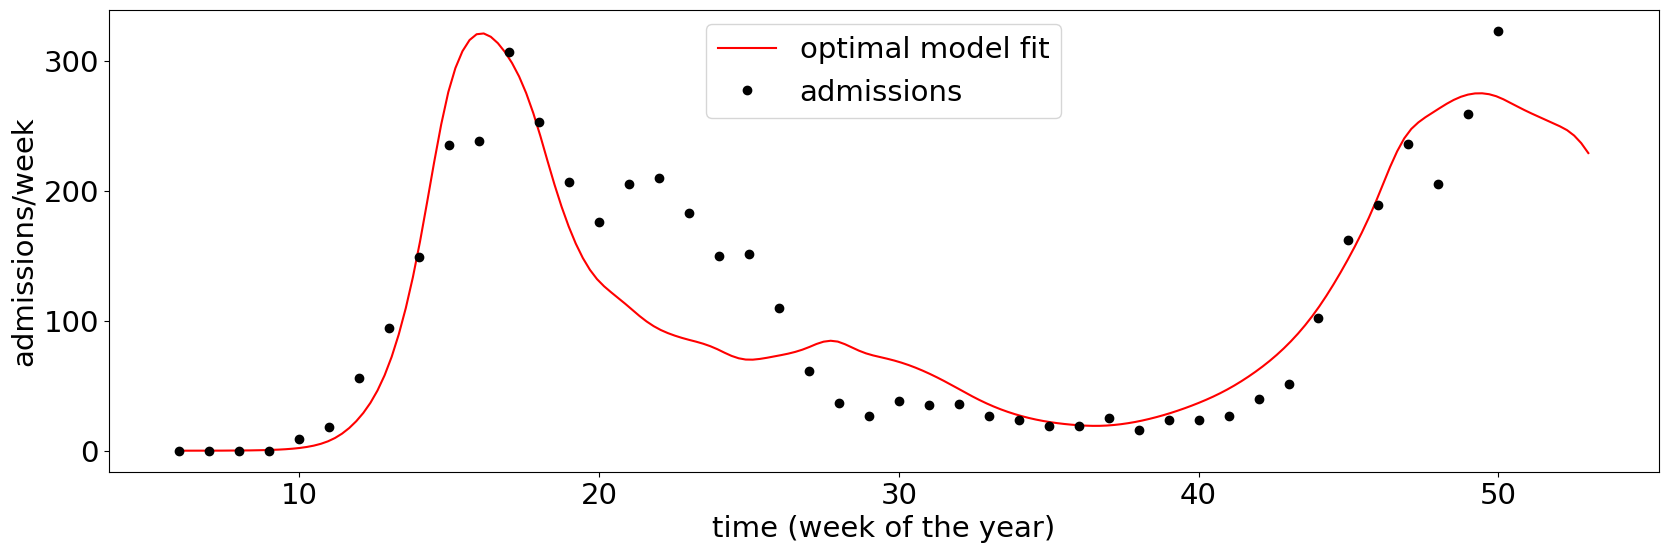

In [76]:
#plot the results
t=np.linspace(0,Tmax-startvecka,200)
fig, axes = plt.subplots(1,1,figsize=(20,6))
pred = pred_inlagda(t,fit[0],fit[1],delay)

axes.plot(t+startvecka,pred,'r',label="optimal model fit")
##axes.plot(t+startvecka,Pu,'k--',label="confidence interval")
#axes.plot(t+startvecka,Pl,'k--')

axes.plot(veckor+startvecka,I,'ko',label="admissions")

axes.set_xlabel('time (week of the year)')
axes.set_ylabel('admissions/week')
axes.legend()

In [ ]:
#save output
tp=np.arange(0,Tmax-startvecka,1)
pred = pred_inlagda(tp,fit[0],fit[1],delay)

np.savetxt('tid.csv',tp+startvecka, delimiter=',')
np.savetxt('inlagda.csv',np.round(pred), delimiter=',')

In [ ]:
#calculate model fit when amount of training data is varied
A=np.array([])
B=np.array([])
RMSE=np.array([])
MAPE=np.array([])

hor=3
tt=np.arange(20-startvecka,len(I)-hor,1)
for k in tt:
    I_train=I[0:k]
    veckor_train=veckor[0:k]
    I_test=I[0:k+hor]
    veckor_test=veckor[0:k+hor]
    
    fit, cov = curve_fit(pred_inlagda,veckor_train,I_train,bounds=([2,2,3-0.001],[7,7,3+0.001]),p0=(afit[0],bfit[0],3))
    
    A=np.append(A,fit[0])
    B=np.append(B,fit[1])
    Pp=pred_inlagda(veckor,fit[0],fit[1],delay)
    ep=np.sqrt(np.sum((Pp[k:k+hor]-I[k:k+hor])**2)/hor)
    mp=np.sum(np.abs(Pp[k:k+hor]-I[k:k+hor])/I[k:k+hor])/hor
        
    RMSE=np.append(RMSE,ep)
    MAPE=np.append(MAPE,mp)
    
    print("k=",k,"a=",A[-1],"b=",B[-1])
    


In [ ]:
#plot how MAPE and parameter estimates change
t=np.linspace(0,41,100)
trans=np.linspace(0,1,len(A))
P=pred_inlagda(t,A[-1],B[-1],delay)
Pt=pred_inlagda(veckor,A[-1],B[-1],delay)


fig, axes = plt.subplots(1,2,figsize=(20,10))

axes[0].plot(tt+0*startvecka,MAPE)
axes[0].set_xlabel('weeks of training data')
axes[0].set_ylabel('MAPE of 3 week prediction')


axes[1].plot(tt+0*startvecka,A,'b',label="$\widehat{a}$")
axes[1].plot(tt+0*startvecka,B,'g',label="$\widehat{b}$")
axes[1].set_xlabel('weeks of training data')
axes[1].set_ylabel('parameter value')
axes[1].legend()

In [ ]:
###